<a href="https://colab.research.google.com/github/DGARNICAG/public/blob/main/Validation_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import sqlite3
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

# 1. Conexión a la base de datos
conn = sqlite3.connect('pharma.db')
cursor = conn.cursor()

# 2. Configuración de los parámetros
num_samples = 100
lote_random = random.randint(1000, 9999)
batch_id = f'LOT-{lote_random}'
start_date = datetime(2026, 1, 15)

# Simularemos datos que sigan una campana de Gauss (Distribución Normal)
# np.random.normal(media, desviación_estándar, cantidad)
weights = np.random.normal(500, 5, num_samples)      # Media 500mg, DE 5
hardness = np.random.normal(12, 0.8, num_samples)    # Media 12kp, DE 0.8
thickness = np.random.normal(4.2, 0.1, num_samples)  # Media 4.2mm, DE 0.1
operators = ['L. Gomez', 'S. Garcia', 'R. Lopez', 'K.Garcia','J. Sanchez']

# 3. Insertar los datos en la tabla
for i in range(num_samples):
    sample_date = (start_date).strftime('%Y-%m-%d')
    op = random.choice(operators)

    cursor.execute('''
        INSERT INTO process_validation (batch_id, test_date, weight_mg, hardness_kp, thickness_mm, operador_id)
        VALUES (?, ?, ?, ?, ?, ?)
    ''', (batch_id, sample_date, round(weights[i], 2), round(hardness[i], 2), round(thickness[i], 2), op))

# 4. Guardar cambios y cerrar
conn.commit()
print(f"¡Éxito! Se han insertado {num_samples} registros de validación.")
conn.close()

¡Éxito! Se han insertado 100 registros de validación.


In [22]:
import sqlite3
import pandas as pd

# 1. Connect to the database
conn = sqlite3.connect('pharma.db')

# 2. Query the data using SQL
query = "SELECT * FROM process_validation"

# 3. Load into a DataFrame (df)
df = pd.read_sql_query(query, conn)

# 4. Show the first rows and data types
print("Data successfully loaded!")
print(df.head())
print("\nTechnical Summary (Data Types):")
print(df.dtypes)
print(df.describe())
conn.close()

Data successfully loaded!
   sample_id  batch_id   test_date  weight_mg  hardness_kp  thickness_mm  \
0          1  LOT-9713  2026-01-15      505.2         12.5           4.2   
1          2  LOT-9713  2026-01-15      497.7         11.8           4.1   
2          3  LOT-9713  2026-01-15      510.5         13.1           4.3   
3          4  LOT-9713  2026-01-15      509.8         12.0           4.1   
4          5  LOT-9713  2026-01-15      506.5         10.1           4.4   

  operador_id  
0    L. Gomez  
1   S. Garcia  
2    R. Lopez  
3   A. Moreno  
4    L. Gomez  

Technical Summary (Data Types):
sample_id         int64
batch_id         object
test_date        object
weight_mg       float64
hardness_kp     float64
thickness_mm    float64
operador_id      object
dtype: object
        sample_id   weight_mg  hardness_kp  thickness_mm
count  110.000000  110.000000   110.000000    110.000000
mean    55.500000  500.244182    11.912636      4.219273
std     31.898276    4.554897     0

In [26]:
# Definir límites de especificación
USL = 525.0
LSL = 429.5

# Extraer media (mean) y desviación estándar (std) de la peso
mean_weight = df['weight_mg'].mean()
std_weight = df['weight_mg'].std()

# Calcular Cpu y Cpl
cpu = (USL - mean_weight) / (3 * std_weight)
cpl = (mean_weight - LSL) / (3 * std_weight)

# El Cpk es el valor mínimo entre ambos
cpk = min(cpu, cpl)

print(f"--- Weight analysis of capacity ---")
print(f"Media: {mean_weight:.2f}")
print(f"Standard deviation : {std_weight:.2f}")
print(f"Cpk: {cpk:.2f}")

if cpk >= 1.33:
    print("State: robust process (Capable)")
else:
    print("State: requires adjustment (Not Capable)")

--- Weight analysis of capacity ---
Media: 500.24
Standard deviation : 4.55
Cpk: 1.81
State: robust process (Capable)


In [27]:
# Definir límites de especificación
USL = 15.0
LSL = 9.0

# Extraer media (mean) y desviación estándar (std) de la dureza
mean_hardness = df['hardness_kp'].mean()
std_hardness = df['hardness_kp'].std()

# Calcular Cpu y Cpl
cpu = (USL - mean_hardness) / (3 * std_hardness)
cpl = (mean_hardness - LSL) / (3 * std_hardness)

# El Cpk es el valor mínimo entre ambos
cpk = min(cpu, cpl)

print(f"--- Hardness analysis of capacity ---")
print(f"Media: {mean_hardness:.2f}")
print(f"Standard deviation : {std_hardness:.2f}")
print(f"Cpk: {cpk:.2f}")

if cpk >= 1.33:
    print("State: robust process (Capable)")
else:
    print("State: requires adjustment (Not Capable)")

--- Hardness analysis of capacity ---
Media: 11.91
Standard deviation : 0.70
Cpk: 1.39
State: robust process (Capable)


In [37]:
!pip install fpdf

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=8aa1da458f34461bafcca64369abbed250315ab6e9a8b23ad581a11b32065a66
  Stored in directory: /root/.cache/pip/wheels/6e/62/11/dc73d78e40a218ad52e7451f30166e94491be013a7850b5d75
Successfully built fpdf


¡Archivo 'Reporte_Final.pdf' listo para descargar!


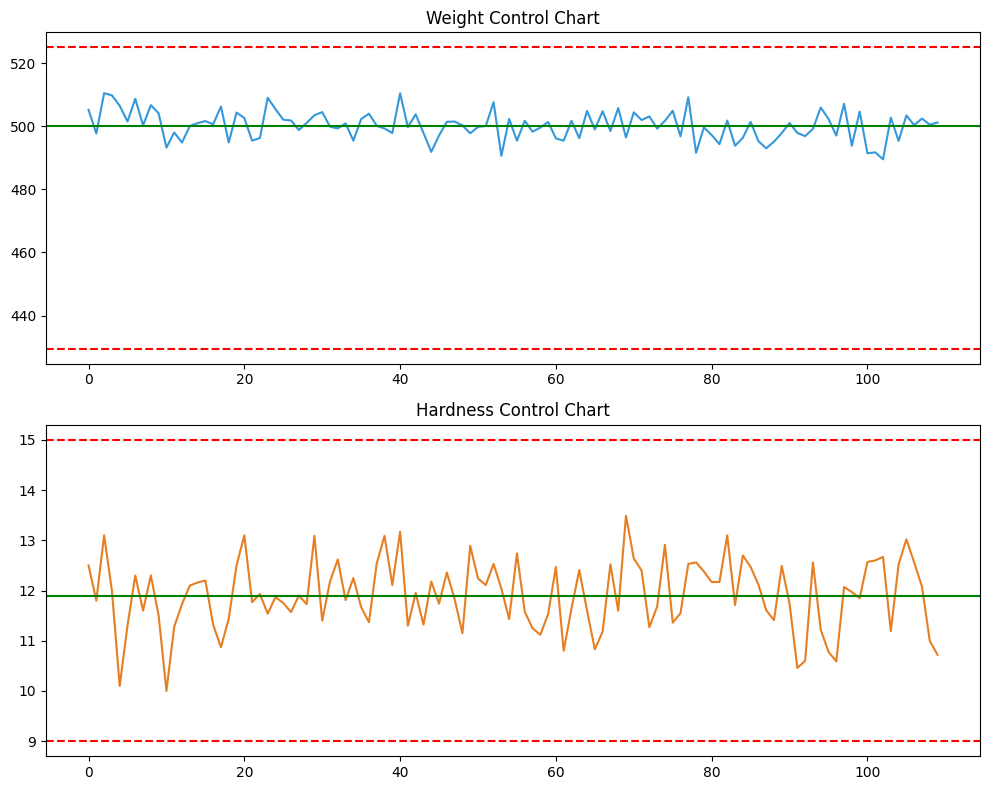

In [45]:
# Guardamos las dos gráficas juntas para que aparezcan en el reporte
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(df['weight_mg'], color='#3498db')
plt.axhline(y=525, color='r', linestyle='--')
plt.axhline(y=429.5, color='r', linestyle='--')
plt.axhline(y=500, color='green', label='Target (500mg)')


plt.title('Weight Control Chart')

plt.subplot(2, 1, 2)
plt.plot(df['hardness_kp'], color='#e67e22')
plt.axhline(y=15, color='r', linestyle='--')
plt.axhline(y=9, color='r', linestyle='--')
plt.axhline(y=11.9, color='green', label='Target (12kp)')
plt.title('Hardness Control Chart')

plt.tight_layout()
plt.savefig("final_report_img.png") # Guardamos la imagen combinada

# Generar el PDF con espacios corregidos
pdf = PDF() # Usamos la clase que ya definiste
pdf.add_page()
pdf.set_font("Arial", size=11)

# Datos del Lote
pdf.cell(0, 10, txt=f"Date: 2026-02-09", ln=True)
pdf.cell(0, 10, txt="Batch ID: LOT-9713", ln=True)
pdf.ln(5)

# Tabla de Resultados
pdf.set_font("Arial", 'B', 12)
pdf.cell(0, 10, txt="1. Statistical Performance Summary", ln=True)
pdf.set_font("Arial", size=10)
pdf.cell(0, 8, txt=f"- Weight Cpk: 1.81 (Status: Highly Capable)", ln=True)
pdf.cell(0, 8, txt=f"- Hardness Cpk: 1.39 (Status: Capable)", ln=True)
pdf.ln(5)

# Insertar Imagen (Ajustamos la posición Y para que no tape el texto)
pdf.image("final_report_img.png", x=10, y=75, w=180)

# Mover el cursor debajo de la imagen para la conclusión
pdf.set_y(220)
pdf.set_font("Arial", 'B', 12)
pdf.cell(0, 10, txt="2. Final Conclusion", ln=True)
pdf.set_font("Arial", size=10)
conclusion = (
    "All tested samples meet the validated acceptance criteria. The weight distribution "
    "shows a high capability index (1.81), while hardness remains stable within limits. "
    "The batch LOT-9713 is compliant with Quality Assurance standards."
)
pdf.multi_cell(0, 8, txt=conclusion)

pdf.output("Reporte_Final.pdf")
print("¡Archivo 'Reporte_Final.pdf' listo para descargar!")